# WAVE Client Data Analysis Example

This notebook demonstrates how to use the WAVE Python client to create and analyze experimental data.

## Prerequisites

1. **WAVE Backend**: Running at `http://localhost:8000`
2. **Dependencies**: Run `make setup-local-dev` and select the python kernel in `.venv`
3. **API Key**: Set `WAVE_API_KEY` in your `.env` file


## Setup

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
from wave_client import WaveClient

# Load environment variables
load_dotenv()
API_KEY = os.getenv('WAVE_API_KEY')
BASE_URL = os.getenv('WAVE_API_URL', 'http://localhost:8000')

if not API_KEY:
    raise ValueError("Please set WAVE_API_KEY in your .env file")

print(f"✓ Connecting to {BASE_URL}")

✓ Connecting to http://localhost:8000


In [2]:
# Initialize client and test connection
client = WaveClient(api_key=API_KEY, base_url=BASE_URL)

# Test connection
health = await client.get_health()
version = await client.get_version()

print(f"✓ Backend status: {health['status']}")
print(f"✓ API version: {version.get('api_version', 'unknown')}")

✓ Backend status: healthy
✓ API version: 1.0.0


## Create Sample Experiment and Data

In [3]:
# Create an experiment type first
try:
    exp_type = await client.experiment_types.create(
        name="Reaction Time Task",
        table_name="reaction_time_data",
        description="Simple reaction time measurement",
        schema_definition={
            "stimulus_type": "STRING",
            "trial_number": "INTEGER",
            "reaction_time": "FLOAT",
            "accuracy": "BOOLEAN",
            "response_confidence": "FLOAT"
        }
    )
    exp_type_id = exp_type['id']
    print(f"✓ Created experiment type: {exp_type['name']} (ID: {exp_type_id})")
except Exception as e:
    print(f"Note: {e} (may already exist)")
    # Get existing experiment type
    exp_types = await client.experiment_types.list_as_dataframe()
    if len(exp_types) > 0:
        exp_type_id = exp_types.iloc[0]['id']
        print(f"✓ Using existing experiment type ID: {exp_type_id}")
    else:
        raise Exception("No experiment types available")

✓ Created experiment type: Reaction Time Task (ID: 1)


In [4]:
# Create a sample experiment
try:
    experiment = await client.experiments.create(
        experiment_type_id=exp_type_id,
        description="Demonstration reaction time study",
        tags=[],  # Empty tags to avoid dependency issues
        additional_data={"researcher": "notebook_demo"}
    )
    experiment_id = str(experiment['uuid'])  # Convert UUID to string
    print(f"✓ Created experiment: {experiment['description']} (ID: {experiment_id})")
except Exception as e:
    print(f"Note: {e} (may already exist)")
    # Get existing experiment
    experiments = await client.experiments.list_as_dataframe()
    if len(experiments) > 0:
        experiment_id = str(experiments.iloc[0]['uuid'])  # Convert UUID to string
        print(f"✓ Using existing experiment ID: {experiment_id}")
    else:
        raise Exception("No experiments available")

✓ Created experiment: Demonstration reaction time study (ID: f3449656-e131-4699-9cf9-50b3fb2bf5c7)


In [5]:
# Generate and insert sample data
import random
import numpy as np

# Create sample reaction time data
participants = [f"P{i:03d}" for i in range(1, 21)]  # 20 participants
stimuli = ["word", "nonword"]

# Track data for summary
total_trials = 0

for participant_id in participants:
    for stimulus in stimuli:
        for trial in range(10):  # 10 trials per condition
            # Generate realistic reaction time data
            base_rt = 600 if stimulus == "word" else 750  # words are faster
            rt = np.random.normal(base_rt, 100)  # Add some noise
            correct = np.random.choice([True, False], p=[0.95, 0.05])  # 95% accuracy
            
            # Convert numpy types to native Python types for JSON serialization
            trial_data = {
                "stimulus_type": stimulus,
                "trial_number": int(trial + 1),
                "reaction_time": float(rt),
                "accuracy": bool(correct),
                "response_confidence": float(np.random.uniform(0.5, 1.0))
            }
            
            # Use new kwargs API - no more data_row dictionary wrapper
            try:
                await client.experiment_data.create(
                    experiment_id=experiment_id,
                    participant_id=participant_id,
                    data=trial_data
                )
                total_trials += 1
            except Exception as e:
                print(f"Error creating data for {participant_id}: {e}")

print(f"✓ Created {total_trials} data points")
print(f"✓ Data for {len(participants)} participants")
print(f"✓ {total_trials // len(participants)} trials per participant on average")

✓ Created 400 data points
✓ Data for 20 participants
✓ 20 trials per participant on average


## Retrieve and Display Data

In [6]:
# Get all experiment data
data_df = await client.experiment_data.get_all_data(experiment_id=experiment_id)
print(f"Retrieved {len(data_df)} data points")

# Display the data
display(data_df)

Retrieved 400 data points


,id,experiment_uuid,participant_id,created_at,updated_at,stimulus_type,trial_number,reaction_time,accuracy,response_confidence
0,400,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P020,2025-08-06 18:43:34.268913,2025-08-06 18:43:34.268913,nonword,10,836.660694,True,0.737213
1,399,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P020,2025-08-06 18:43:34.253040,2025-08-06 18:43:34.253040,nonword,9,883.297780,True,0.756814
2,398,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P020,2025-08-06 18:43:34.235646,2025-08-06 18:43:34.235646,nonword,8,637.936886,True,0.891419
3,397,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P020,2025-08-06 18:43:34.219026,2025-08-06 18:43:34.219026,nonword,7,771.767625,True,0.873685
4,396,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P020,2025-08-06 18:43:34.202948,2025-08-06 18:43:34.202948,nonword,6,608.122120,True,0.520781
...,...,...,...,...,...,...,...,...,...,...
395,5,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P001,2025-08-06 18:43:27.524208,2025-08-06 18:43:27.524208,word,5,654.960862,True,0.760942
396,4,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P001,2025-08-06 18:43:27.507677,2025-08-06 18:43:27.507677,word,4,584.096374,True,0.680933
397,3,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P001,2025-08-06 18:43:27.486724,2025-08-06 18:43:27.486724,word,3,597.934539,True,0.667809
398,2,f3449656-e131-4699-9cf9-50b3fb2bf5c7,P001,2025-08-06 18:43:27.463952,2025-08-06 18:43:27.463952,word,2,550.100179,False,0.514416


In [7]:
# Basic statistics
print("Basic Statistics:")
print(f"Mean reaction time: {data_df['reaction_time'].mean():.3f} seconds")
print(f"Overall accuracy: {data_df['accuracy'].mean():.1%}")
print(f"Participants: {data_df['participant_id'].nunique()}")

# Descriptive statistics for numeric columns
display(data_df[['reaction_time', 'response_confidence']].describe())

Basic Statistics:
Mean reaction time: 672.004 seconds
Overall accuracy: 93.8%
Participants: 20


,reaction_time,response_confidence
count,400.000000,400.000000
mean,672.003795,0.739949
std,127.832655,0.145374
min,282.520505,0.500342
25%,581.530771,0.613472
50%,665.545206,0.746053
75%,761.717737,0.861284
max,990.487564,0.999262


## Simple Visualization

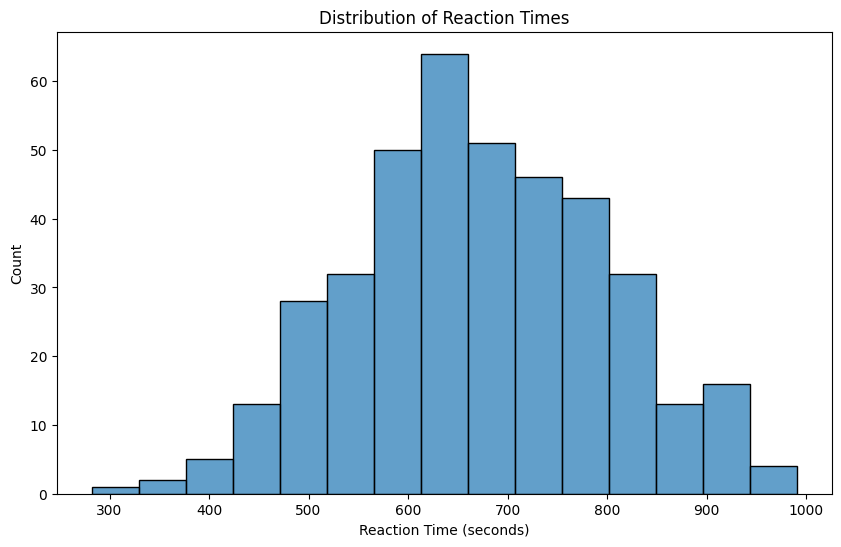

In [8]:
# Create a simple histogram of reaction times
plt.figure(figsize=(10, 6))
sns.histplot(data=data_df, x='reaction_time', bins=15, alpha=0.7)
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time (seconds)')
plt.ylabel('Count')
plt.show()

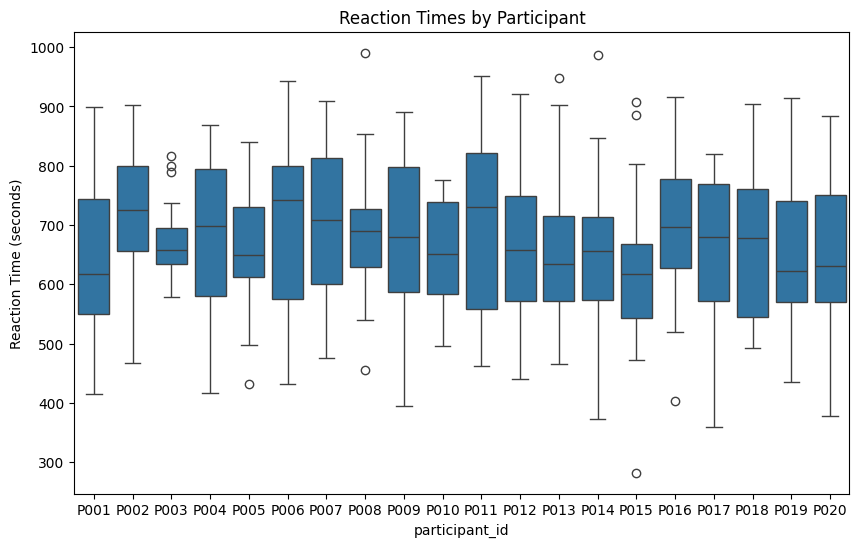

In [9]:
# Reaction times by participant
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_df, x='participant_id', y='reaction_time')
plt.title('Reaction Times by Participant')
plt.ylabel('Reaction Time (seconds)')
plt.show()

## Participant-Level Analysis

In [10]:
# Aggregate by participant
participant_summary = data_df.groupby('participant_id').agg({
    'reaction_time': ['count', 'mean', 'std'],
    'accuracy': 'mean'
}).round(3)

# Flatten column names
participant_summary.columns = ['trials', 'rt_mean', 'rt_std', 'accuracy']
participant_summary = participant_summary.reset_index()

print("Participant Summary:")
display(participant_summary)

Participant Summary:


/var/folders/b9/by4645sj1qs3zlbv_gjj27_c0000gp/T/ipykernel_70874/1661987946.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  participant_summary = data_df.groupby('participant_id').agg({


,participant_id,trials,rt_mean,rt_std,accuracy
0,P001,20,646.496,132.740,0.90
1,P002,20,724.750,109.991,0.95
2,P003,20,673.837,67.733,1.00
3,P004,20,681.331,141.099,0.90
4,P005,20,660.160,101.797,0.95
5,P006,20,689.179,156.272,1.00
6,P007,20,708.238,134.384,0.95
7,P008,20,689.445,115.614,0.95
8,P009,20,685.948,134.640,0.95
9,P010,20,652.804,88.497,0.80


## Search and Filter Examples

In [16]:
# Filter data examples
print("Data filtering examples:")

# Fast responses (< 700ms)
fast_responses = data_df[data_df['reaction_time'] < 0.7]
print(f"Fast responses (< 0.7s): {len(fast_responses)} trials")

# Correct responses only
correct_only = data_df[data_df['accuracy'] == True]
print(f"Correct responses: {len(correct_only)} trials")

# Participant P001 data
p001_data = data_df[data_df['participant_id'] == 'P001']
print(f"P001 data: {len(p001_data)} trials")

# Word stimulus trials
word_trials = data_df[data_df['stimulus_type'] == 'word']
print(f"Word stimulus trials: {len(word_trials)} trials")

Data filtering examples:
Fast responses (< 0.7s): 0 trials
Correct responses: 375 trials
P001 data: 20 trials
Word stimulus trials: 200 trials


In [12]:
# Search experiments
all_experiments = await client.experiments.list_as_dataframe()
display(all_experiments)

,description,tags,additional_data,uuid,experiment_type_id,created_at,updated_at,type_name,type_description,type_table_name,type_schema_definition,type_id,type_created_at,type_updated_at
0,Demonstration reaction time study,[],{'researcher': 'notebook_demo'},f3449656-e131-4699-9cf9-50b3fb2bf5c7,1,2025-08-06 18:43:27.258457+00:00,2025-08-06 18:43:27.258457+00:00,Reaction Time Task,Simple reaction time measurement,reaction_time_data,"{'stimulus_type': 'STRING', 'trial_number': 'I...",1,2025-08-06 18:43:27.208955+00:00,2025-08-06 18:43:27.208955+00:00


## Clean Up

## Delete Experiment Data

Clean up by deleting the experiment and experiment type created for this demo.

Deleting data requires an Admin level API key

In [13]:
# Delete experiment data first
print("Deleting experiment data...")
try:
    # Get all data rows to delete them individually
    all_data = await client.experiment_data.get_all_data(experiment_id)
    
    if len(all_data) > 0:
        deleted_count = 0
        for _, row in all_data.iterrows():
            try:
                await client.experiment_data.delete_row(experiment_id, int(row['id']))
                deleted_count += 1
            except Exception as e:
                print(f"  Failed to delete row {row['id']}: {e}")
        
        print(f"✓ Deleted {deleted_count} experiment data rows")
    else:
        print("✓ No experiment data to delete")
        
except Exception as e:
    print(f"Note: Could not delete experiment data: {e}")

# Now delete the experiment
try:
    delete_response = await client.experiments.delete(experiment_id)
    print(f"✓ Deleted experiment: {experiment_id}")
    print(f"  Response: {delete_response.get('message', 'Success')}")
except Exception as e:
    print(f"Note: Could not delete experiment: {e}")

# Optionally, also delete the experiment type if it was created for this demo
try:
    delete_type_response = await client.experiment_types.delete(exp_type_id)
    print(f"✓ Deleted experiment type: {exp_type_id}")
    print(f"  Response: {delete_type_response.get('message', 'Success')}")
except Exception as e:
    print(f"Note: Could not delete experiment type: {e}")

Deleting experiment data...
✓ Deleted 400 experiment data rows
✓ Deleted experiment: f3449656-e131-4699-9cf9-50b3fb2bf5c7
  Response: Experiment deleted successfully
✓ Deleted experiment type: 1
  Response: Experiment type deleted successfully
✓ Deleted 400 experiment data rows
✓ Deleted experiment: f3449656-e131-4699-9cf9-50b3fb2bf5c7
  Response: Experiment deleted successfully
✓ Deleted experiment type: 1
  Response: Experiment type deleted successfully


In [14]:
all_experiments = await client.experiments.list_as_dataframe()
display(all_experiments)

""


In [15]:
# # Close client connection
# await client.close()
# print("✓ Client connection closed")